# Idealised weight process

In [287]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import lines
import copy
import time
import sys
import math
from IPython.display import clear_output
np.set_printoptions(threshold=sys.maxsize)
rng = np.random.default_rng()

In [288]:
def simulate_weights_coupled(p=[0.5], N=1000, n=1000000, idealized=False, Weights="None"):
    """
    Simulates coupled weights for same reproduction events for different values of the paternal bias p
    (backwards in time). The Model is a biparental Moran model.
    
            Parameters:
                    p (float or list of floats in [0,1]): Portion of any individual's weight that splits off to mother.
                    N (int): Population size.
                    n (int): Number of time steps.
                    idealized (bool): If 'True', coupled idealized process (for p=1/N^2) is simulated.
                    Weights (real np.array of shape (len[p]+idealized,N)): Starting weights of population.  
                    Previously simulated weights can be inserted to continue the simulation.
                    
            Returns:
                    Weights (list of np_arrays of shape (len[p]+idealized,N)): List of weights of population n time 
                    steps in the past for all values of p. Idealized weights are last.
    
    """
    if isinstance(p, float): 
        p = [p]
    num_experiments = len(p) #Number of separate weight vectors are needed
    
    if idealized: #Algorithm is different for idealized weights
        if Weights == "None": #If no starting weights are given, they are generated as the weights of the population at time 0
            Weights = np.ones(shape=(num_experiments+1, N))
            for j in range(N-1):
                Weights[num_experiments][j] = 0
            Weights[num_experiments] = Weights[num_experiments]*N
        indices = np.arange(0, N, 1, dtype=int)
        
        print("Simulating weights:") #Plots progress bar
        clear_output(wait=True)
        
        for i in range(n): #Simulates weights over n time steps
            kappa, pi, mu = rng.choice(indices, size=3, replace=False)
            for j in range(num_experiments): #First block: Transition of weight process. Second block: Transition of idealized
                Weights[j][pi] = Weights[j][pi] + (p[j])*Weights[j][kappa]
                Weights[j][mu] = Weights[j][mu] + (1-p[j])*Weights[j][kappa]
                Weights[j][kappa] = 0
                
            if Weights[num_experiments][kappa] > Weights[num_experiments][mu]: 
                Weights[num_experiments][mu] = Weights[num_experiments][kappa]
            if Weights[num_experiments][kappa] > Weights[num_experiments][pi]:
                Weights[num_experiments][pi] = Weights[num_experiments][kappa]/(N**2)
            Weights[num_experiments][kappa] = 0
            
            if (i % 10000) == 0: #Updates progress bar every 10.000 tiem steps
                print("\rSimulating weights: " + str(round((100*i)/n)) + "%")
                clear_output(wait=True)
    else: #Same algorithm without idealized weights
        if Weights == "None":
            Weights = np.ones(shape=(num_experiments, N))
        indices = np.arange(0, N, 1, dtype=int)
        
        print("Simulating weights:")
        clear_output(wait=True)
        
        for i in range(n):
            kappa, pi, mu = rng.choice(indices, size=3, replace=False)
            for j in range(num_experiments):
                Weights[j][pi] = Weights[j][pi] + (p[j])*Weights[j][kappa]
                Weights[j][mu] = Weights[j][mu] + (1-p[j])*Weights[j][kappa]
                Weights[j][kappa] = 0
                
            if (i % 10000) == 0:
                print("\rSimulating weights: " + str(round((100*i)/n)) + "%")
                clear_output(wait=True)
                
    print("Simulating weights: 100%")
    clear_output(wait=True)
    
    return Weights

In [289]:
def simulate_weights_fast(p=0.5, N=1000, n=1000000):
    """
    Simulates weights for a biparental Moran model with parental bias p. Only slightly faster because progress bar is less 
    accurate.
    """
    Weights = np.ones(N)
    indices = np.arange(0, N, 1, dtype=int)
    print("Simulating weights:")
    clear_output(wait=True)
    for i in range(n):
        kappa, pi, mu = rng.choice(indices, size=3, replace=False)
        Weights[pi] = Weights[pi] + (p)*Weights[kappa]
        Weights[mu] = Weights[mu] + (1-p)*Weights[kappa]
        Weights[kappa] = 0
        if (i % 100000) == 0:
            print("\rSimulating weights: " + str(round((100*i)/n)) + "%")
            clear_output(wait=True)
    print("Simulating weights: 100%")
    clear_output(wait=True)
    return Weights

In [290]:
def adjust_idealized_to_p(Idealized_Weights, p_new, p_old = 1/1000000):
    """
    Is used to turn the idealized process for p=1/N^2 into the idealized process for a new value of p.
    """
    N = len(list(Idealized_Weights))
    Idealized_Weights_new_p = np.zeros(N)
    classes = sort_by_potency_of_p(Idealized_Weights, p_old, no_print = True)
    weight_class = N
    for clas in classes:
        for ind in clas:
            Idealized_Weights_new_p[ind] = weight_class
        weight_class *= p_new
        
    return Idealized_Weights_new_p

In [319]:
def smart_class_widths_by_p(Weights, p):
    """
    Classifies weights according to k in Np^k in the log (base N) space. Class 0 is set to contain only the largest weight.
    In the log plot, all calles are exactly a distance of p apart. 
    Therefore the cut offs (in the log plot) between them are: log_N(largest weight) - log_N(p) - epsilon.
    The epsilon is there to account for decay of the weights and should depend on 1-p. 
    
            Parameters:
                    Weights (np_array of shape (,N)): Weights of population
                    p (float in [0,1]): Portion of any individual's weight that splits off to mother.
                    
            Returns:
                    class_widths (list of lits of form [str,int]): List of widths of the classes and names. 
                    Classes are ordered from biggest to smallest weight.
    """
    N = len(list(Weights))
    basis_factor = np.log10(N)
    distance_between_classes = -np.log10(p)/basis_factor
    Weights.sort()
    classes = [] # not returned but could be
    indices = np.arange(0, N, 1, dtype=int)
    i = N-2
    current_class = []
    current_cut_off = np.log10(Weights[-1])/basis_factor - distance_between_classes - 0.1 
    "0.1 is set from experience. This should depend on (1-p), as this determines the decay"
    class_boundaries = [current_cut_off] # not returned but could be                                                 
    counter = 0                                                                          
    class_widths = [["Klasse 1", 1]]
    
    while i >= 0:
        
        if Weights[i] == 0:
            break
            
        while np.log10(Weights[i])/basis_factor >= current_cut_off:
            current_class.append(i)
            i -= 1
            
        if Weights[i] == 0:
            classes.append(current_class)
            counter += 1
            class_widths.append(["Klasse " + str(counter), len(current_class)])
            break
            
        if np.log10(Weights[i])/basis_factor < current_cut_off:
            classes.append(current_class)
            counter += 1
            class_widths.append(["Klasse " + str(counter), len(current_class)])
            current_class = []
            current_cut_off -= distance_between_classes
            class_boundaries.append(current_cut_off)
            
    return class_widths

### Example

In [317]:
start = time.time()

N = 1000
n = 1000000

indices = np.arange(0, N, 1, dtype=int)
weights_coupled = simulate_weights_coupled(p=[0.5, 1/np.sqrt(N), 1/N, 1/(N**2)], n=n, idealized=True)
weights_coupled.sort()

end = time.time()
print(str(round(end-start)) + " seconds")

29 seconds


C:\Users\konst\AppData\Local\Temp/ipykernel_4984/3169131097.py:15: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[0]), s=80, edgecolors = "tab:blue", facecolors='none', linewidths = 0.8)
C:\Users\konst\AppData\Local\Temp/ipykernel_4984/3169131097.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[1]), s=80, edgecolors = "tab:orange", facecolors='none', linewidths = 0.8)
C:\Users\konst\AppData\Local\Temp/ipykernel_4984/3169131097.py:17: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[2]), s=80, edgecolors = "tab:green", facecolors='none', linewidths = 0.8)
C:\Users\konst\AppData\Local\Temp/ipykernel_4984/3169131097.py:18: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[3]), s=80, edgecolors = "tab:red", facecolors='none', linewidths = 0.8)
C:\Users\konst\AppData\Local\Temp/ipykerne

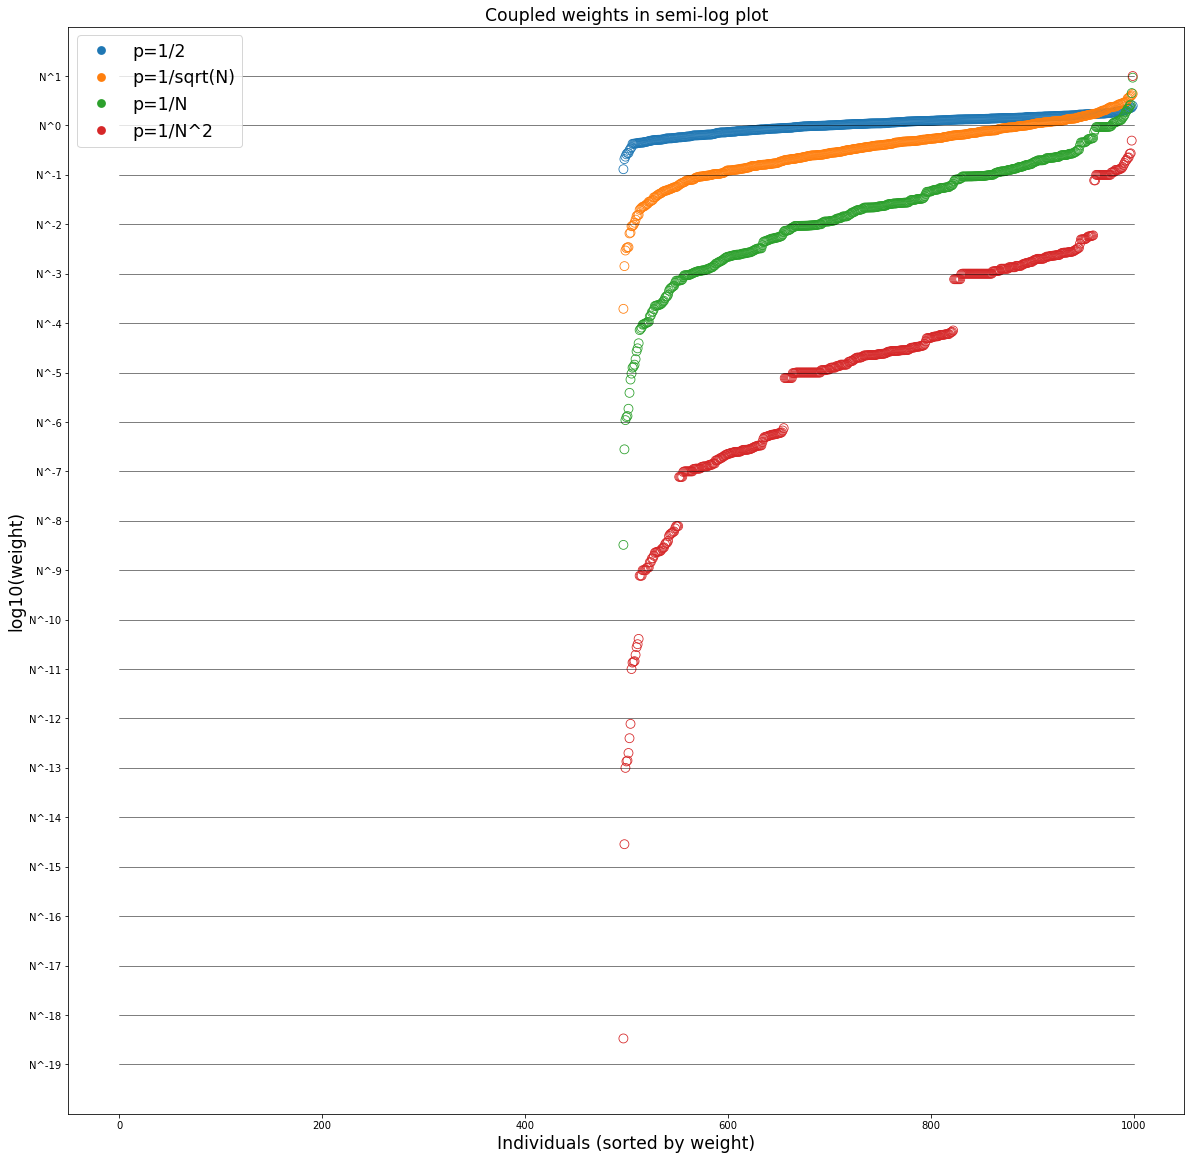

In [293]:
# RuntimeWarning due to approx. half the weights beeing 0 and log taken, not important.

factor = np.log10(N) # Semi-log plot is done with base 10
first_non_zero = np.where(weights_coupled[0] != 0)[0][0] # First strictly positive weight. Independent of p
low = round(np.log10(weights_coupled[3][first_non_zero])) # Lowest strictly positive weight for p=1/N^2
my_yticks = [] # For labeling of y-axis
tick_positions = [] # For labeling of y-axis

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(20, 20) # Determines size of plot
#ax.set_xlim([first_non_zero-15, N+15]) # Can be used to only show strictly positive weights

# Plots the weights for the different values of p
ax.scatter(indices, np.log10(weights_coupled[0]), s=80, edgecolors = "tab:blue", facecolors='none', linewidths = 0.8)
ax.scatter(indices, np.log10(weights_coupled[1]), s=80, edgecolors = "tab:orange", facecolors='none', linewidths = 0.8)
ax.scatter(indices, np.log10(weights_coupled[2]), s=80, edgecolors = "tab:green", facecolors='none', linewidths = 0.8)
ax.scatter(indices, np.log10(weights_coupled[3]), s=80, edgecolors = "tab:red", facecolors='none', linewidths = 0.8)


for i in range(abs(math.floor(low/factor))+2): # Plots the necessary horizontal lines at potencies of N
    power_of_N = int(-factor*i+factor)
    ax.plot([0,N], [power_of_N, power_of_N], color="black", linewidth=0.5)
    my_yticks.append("N^"+str(-i+1))
    tick_positions.append(power_of_N)

    
red_circle = lines.Line2D([], [], color="tab:red", marker='o', linestyle='None', markersize=7, # Just for legend
                          markeredgewidth=1.8, label='p=1/N^2')
green_circle = lines.Line2D([], [], color="tab:green", marker='o', linestyle='None', markersize=7, # Just for legend
                          markeredgewidth=1.8, label='p=1/N') 
orange_circle = lines.Line2D([], [], color="tab:orange", marker='o', linestyle='None', markersize=7, # Just for legend
                          markeredgewidth=1.8, label='p=1/sqrt(N)') 
blue_circle = lines.Line2D([], [], color="tab:blue", marker='o', linestyle='None', markersize=7, # Just for legend
                          markeredgewidth=1.8, label='p=1/2') 
   

ax.set_yticklabels(my_yticks) # Labeling of the y-axis      
ax.set_yticks(tick_positions) # Labeling of the y-axis      
plt.xlabel("Individuals (sorted by weight)", fontsize="xx-large")
plt.ylabel("log10(weight)", fontsize="xx-large")
plt.title("Coupled weights in semi-log plot", fontsize="xx-large")
plt.legend(handles = [blue_circle, orange_circle, green_circle, red_circle], fontsize="xx-large", loc="upper left")

C:\Users\konst\AppData\Local\Temp/ipykernel_4984/1040637257.py:15: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[3]), s=80, edgecolors = "tab:red", facecolors='none', linewidths = 1)
C:\Users\konst\AppData\Local\Temp/ipykernel_4984/1040637257.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(ideal), s=80, edgecolors = "tab:blue", facecolors='none', linewidths = 1)
C:\Users\konst\AppData\Local\Temp/ipykernel_4984/1040637257.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(my_yticks) # Labeling of the y-axis


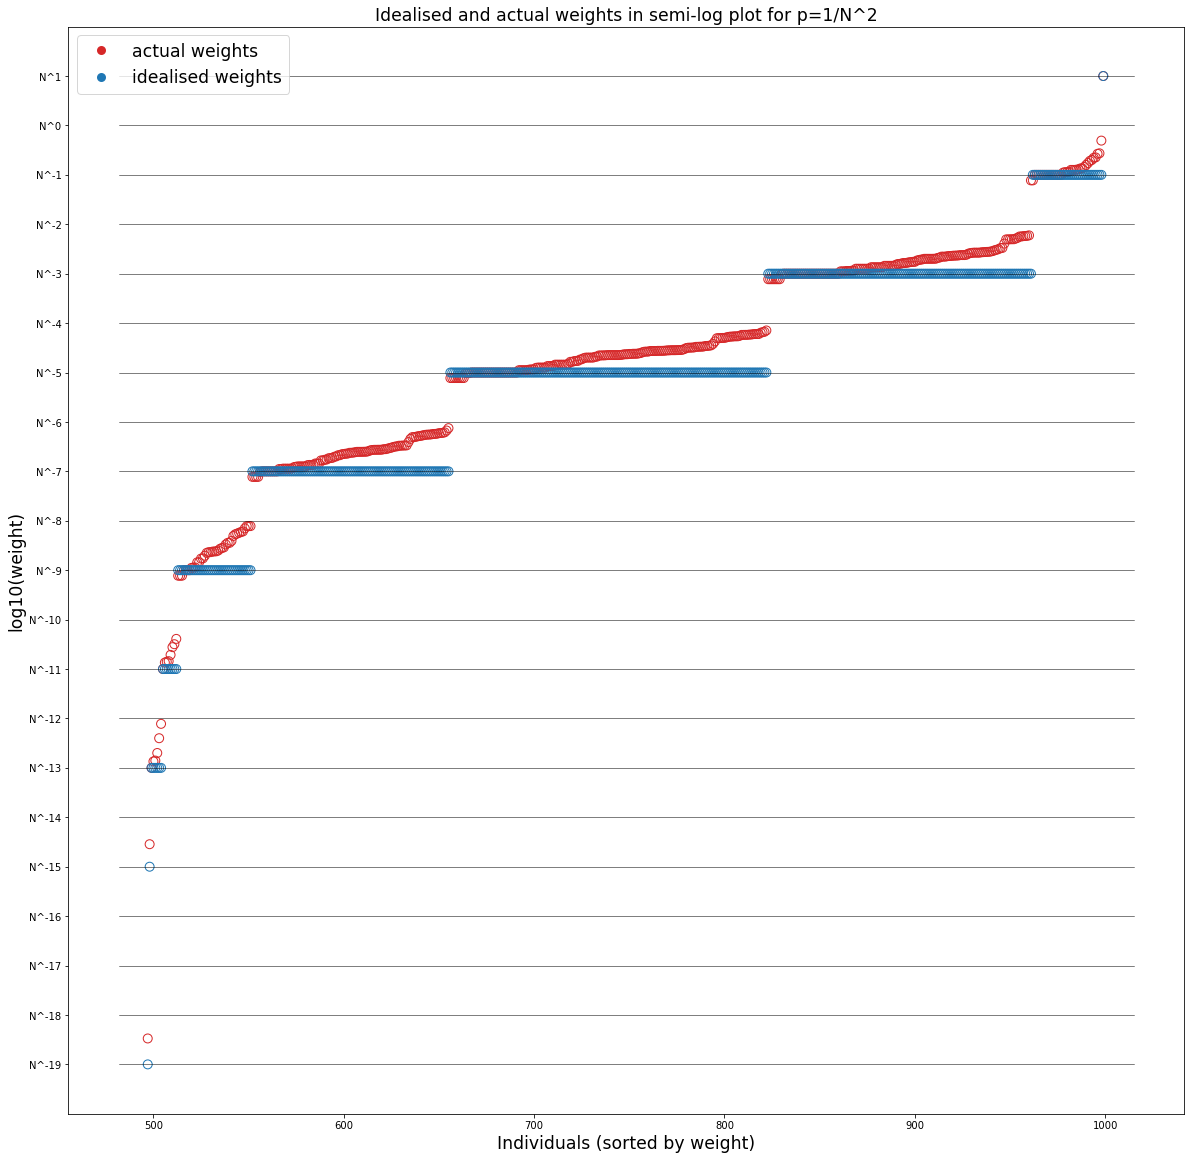

In [294]:
# RuntimeWarning due to approx. half the weights beeing 0 and log taken, not important.

factor = np.log10(N) # Semi-log plot is done with base 10
first_non_zero = np.where(weights_coupled[0] != 0)[0][0] # First strictly positive weight. Independent of p
low = round(np.log10(weights_coupled[3][first_non_zero])) # Lowest strictly positive weight for p=1/N^2
ideal = copy.deepcopy(weights_coupled[4])
my_yticks = [] # For labeling of y-axis
tick_positions = [] # For labeling of y-axis

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(20, 20) # Determines size of plot

# Plots the weights for the different values of p
ax.scatter(indices, np.log10(weights_coupled[3]), s=80, edgecolors = "tab:red", facecolors='none', linewidths = 1)
ax.scatter(indices, np.log10(ideal), s=80, edgecolors = "tab:blue", facecolors='none', linewidths = 1)


for i in range(abs(math.floor(low/factor))+2): # Plots the necessary horizontal lines at potencies of N
    power_of_N = int(-factor*i+factor)
    ax.plot([first_non_zero-15,N+15], [power_of_N, power_of_N], color="black", linewidth=0.5)
    my_yticks.append("N^"+str(-i+1))
    tick_positions.append(power_of_N)

    
blue_circle = lines.Line2D([], [], color="tab:blue", marker='o', linestyle='None', markersize=7, # Just for legend
                          markeredgewidth=2, label="idealised weights") 
red_circle = lines.Line2D([], [], color="tab:red", marker='o', linestyle='None', markersize=7, # Just for legend
                          markeredgewidth=2, label="actual weights") 
   

ax.set_yticklabels(my_yticks) # Labeling of the y-axis      
ax.set_yticks(tick_positions) # Labeling of the y-axis      
plt.xlabel("Individuals (sorted by weight)", fontsize="xx-large")
plt.ylabel("log10(weight)", fontsize="xx-large")
plt.title("Idealised and actual weights in semi-log plot for p=1/N^2", fontsize="xx-large")
plt.legend(handles = [red_circle, blue_circle], fontsize="xx-large", loc="upper left")

### Commentary: The similarities are obvious and occur despite the real weights staring in (1,...,1) and the idealised weights starting in (N,0,...,0). The class-divison occurs for any starting distribution that was tried.

C:\Users\konst\AppData\Local\Temp/ipykernel_4984/558691898.py:15: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[2]), s=80, edgecolors = "tab:green", facecolors='none', linewidths = 1.3)
C:\Users\konst\AppData\Local\Temp/ipykernel_4984/558691898.py:16: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(ideal), s=80, edgecolors = "tab:blue", facecolors='none', linewidths = 1.3)
C:\Users\konst\AppData\Local\Temp/ipykernel_4984/558691898.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(my_yticks) # Labeling of the y-axis


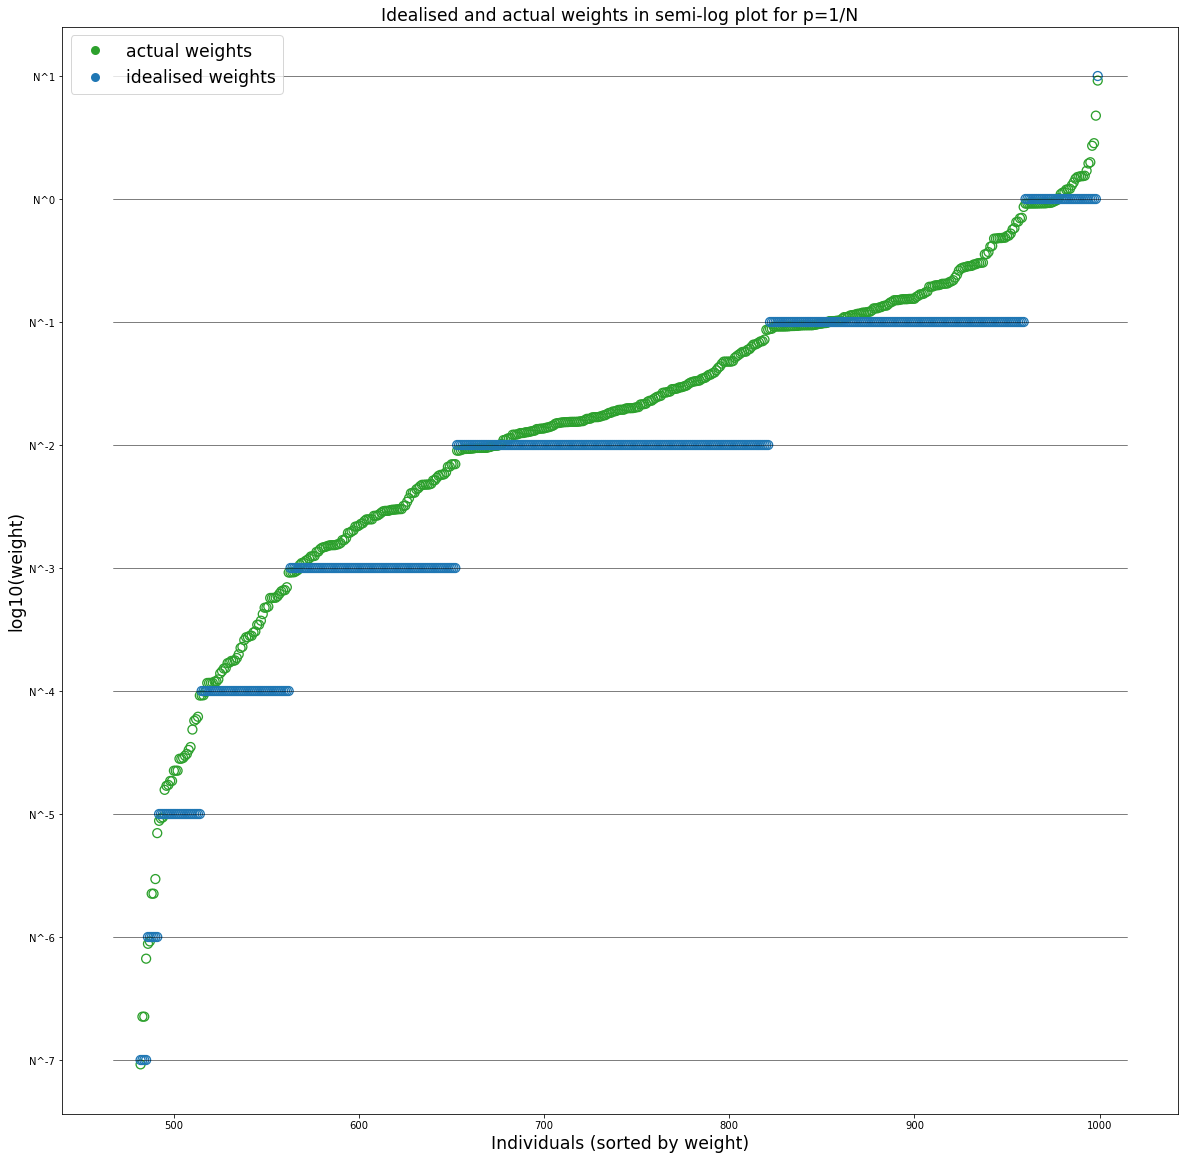

In [301]:
# RuntimeWarning due to approx. half the weights beeing 0 and log taken, not important.

factor = np.log10(N) # Semi-log plot is done with base 10
first_non_zero = np.where(weights_coupled[0] != 0)[0][0] # First strictly positive weight. Independent of p
low = round(np.log10(weights_coupled[2][first_non_zero])) # Lowest strictly positive weight for p=1/N
ideal = adjust_idealized_to_p(weights_coupled[4], p_new=1/N, p_old=1/(N**2)) # Adjust ideal process to p=1/N
my_yticks = [] # For labeling of y-axis
tick_positions = [] # For labeling of y-axis

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(20, 20) # Determines size of plot

# Plots the weights for the different values of p
ax.scatter(indices, np.log10(weights_coupled[2]), s=80, edgecolors = "tab:green", facecolors='none', linewidths = 1.3)
ax.scatter(indices, np.log10(ideal), s=80, edgecolors = "tab:blue", facecolors='none', linewidths = 1.3)


for i in range(abs(math.floor(low/factor))+2): # Plots the necessary horizontal lines at potencies of N
    power_of_N = int(-factor*i+factor)
    ax.plot([first_non_zero-15,N+15], [power_of_N, power_of_N], color="black", linewidth=0.5)
    my_yticks.append("N^"+str(-i+1))
    tick_positions.append(power_of_N)

    
blue_circle = lines.Line2D([], [], color="tab:blue", marker='o', linestyle='None', markersize=7, # Just for legend
                          markeredgewidth=2, label="idealised weights") 
green_circle = lines.Line2D([], [], color="tab:green", marker='o', linestyle='None', markersize=7, # Just for legend
                          markeredgewidth=2, label="actual weights") 
   

ax.set_yticklabels(my_yticks) # Labeling of the y-axis      
ax.set_yticks(tick_positions) # Labeling of the y-axis      
plt.xlabel("Individuals (sorted by weight)", fontsize="xx-large")
plt.ylabel("log10(weight)", fontsize="xx-large")
plt.title("Idealised and actual weights in semi-log plot for p=1/N", fontsize="xx-large")
plt.legend(handles = [green_circle, blue_circle], fontsize="xx-large", loc="upper left")

## Calculated class widths and actual weights

### Calculated class widths of idealized process for N=1000 under assumption that prior classes are of constant size. Cut off after class 11.

#### Class1: 1 <br /> Class2: 30.62 <br /> Class3: 131.55 <br /> Class4: 167.75 <br /> Class5: 102.56 <br /> Class6: 43.27 <br /> Class7: 15.67 <br /> Class8: 5.37 <br /> Class9: 1.8 <br /> Class10: 0.6 <br /> Class11: 0.2
#### sum = 500.39

#### The calculated class widths will be plotted centered around the empirical mid poitn of the class to avoid error multiplication. Therefore the plotted border overlapp or don't touch resprectively.

C:\Users\konst\AppData\Local\Temp/ipykernel_4984/113706901.py:35: RuntimeWarning: divide by zero encountered in log10
  while np.log10(Weights[i])/basis_factor >= current_cut_off:
C:\Users\konst\AppData\Local\Temp/ipykernel_4984/2425708603.py:10: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[3]), edgecolors = "tab:blue", facecolors='none', linewidths = 0.4,


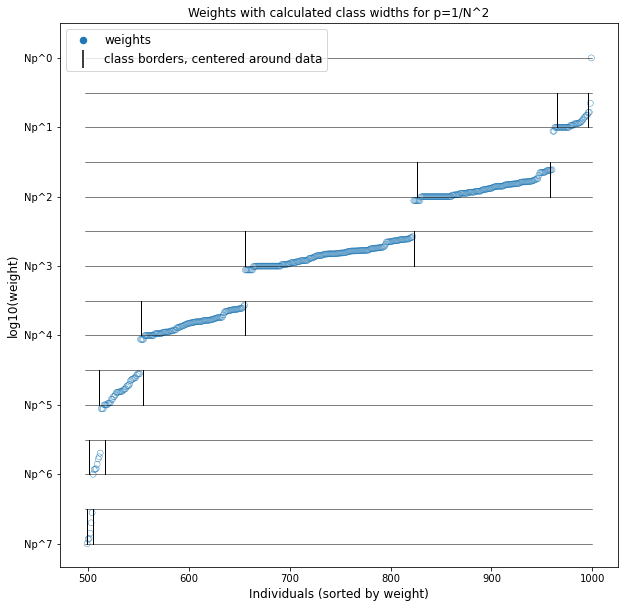

In [296]:
factor = np.log10(N)
first_non_zero = np.where(weights_coupled[0] != 0)[0][0] # Independent of p
class_widths = np.array(smart_class_widths_by_p(weights_coupled[3], p=1/(N**2)))[:,1].astype(int)
calculated_widths = [1, 30.62, 131.55, 167.75, 102.56, 43.27, 15.67, 5.37]
low = round(np.log10(weights_coupled[3][first_non_zero]))

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(10, 10)
ax.scatter(indices, np.log10(weights_coupled[3]), edgecolors = "tab:blue", facecolors='none', linewidths = 0.4,
           label = "Gewichte")

class_sum = 1
for i in range(1, 8): # Has to be a simulation with at least 8 classes
    mid_point = N - class_sum - 0.5*class_widths[i]
    left = mid_point - 0.5*calculated_widths[i]
    right = mid_point + 0.5*calculated_widths[i]
    ax.plot([left, left], [(-2*i+1)*factor, (-2*i+2)*factor], color="black", linewidth=1)
    ax.plot([right, right], [(-2*i+1)*factor, (-2*i+2)*factor], color="black", linewidth=1)
    class_sum += class_widths[i]

for i in range(abs(math.floor(low/factor))+2): # Plots the necessary horizontal lines at potencies of N
    ax.plot([first_non_zero,N], [-(factor*i)+factor, -(factor*i)+factor], color="black", linewidth=0.5)

red_circle = lines.Line2D([], [], color='tab:blue', marker='o', linestyle='None', markersize=6, # Just for legend
                          markeredgewidth=1.5, label='weights')
vertical_line = lines.Line2D([], [], color='black', marker='|', linestyle='None', markersize=18, # Just for legend
                             markeredgewidth=1.5, label='class borders, centered around data')

my_yticks = ["Np^"+str(-i+1) for i in range(1, -7, -1)]
ax.set_yticks([6*i-3 for i in range(1, -7, -1)])
ax.set_yticklabels(my_yticks)   
ax.set_ylim([-41, None])

plt.xlabel("Individuals (sorted by weight)", fontsize="large")
plt.ylabel("log10(weight)", fontsize="large")
plt.title("Weights with calculated class widths for p=1/N^2", fontsize="large")
plt.legend(handles = [red_circle, vertical_line], fontsize="large", loc='upper left')

C:\Users\konst\AppData\Local\Temp/ipykernel_4984/3351726309.py:35: RuntimeWarning: divide by zero encountered in log10
  while np.log10(Weights[i])/basis_factor >= current_cut_off:
C:\Users\konst\AppData\Local\Temp/ipykernel_4984/1908099824.py:11: RuntimeWarning: divide by zero encountered in log10
  ax.scatter(indices, np.log10(weights_coupled[2]), edgecolors = "tab:green", facecolors='none', linewidths = 0.4,


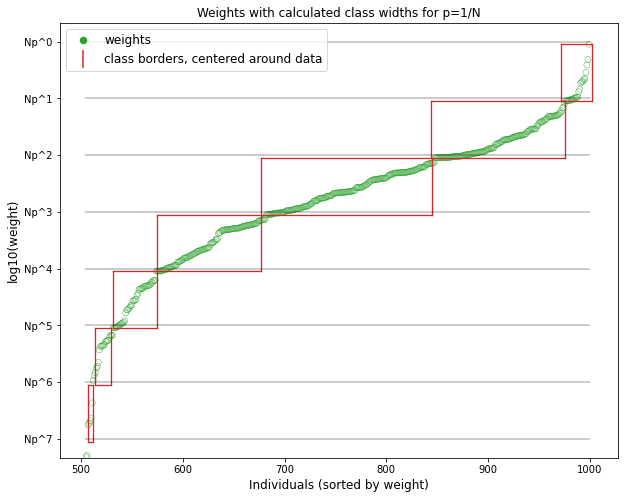

In [321]:
factor = np.log10(N)
first_non_zero = np.where(weights_coupled[0] != 0)[0][0] # Independent of p
class_widths = np.array(smart_class_widths_by_p(weights_coupled[2], p=1/N))[:,1].astype(int) # Classifies weights by Np^k
calculated_widths = [1, 30.62, 131.55, 167.75, 102.56, 43.27, 15.67, 5.37]
low = round(np.log10(weights_coupled[2][first_non_zero]))
dist_max_to_N_log = np.log10(N/np.max(weights_coupled[2]))/factor

ax = plt.gca()
fig = plt.gcf()
fig.set_size_inches(10, 8)
ax.scatter(indices, np.log10(weights_coupled[2]), edgecolors = "tab:green", facecolors='none', linewidths = 0.4,
           label = "Gewichte")
ax.set_ylim([-19, None])

class_sum = 1
for i in range(1, 8): # Has to be a simulation with at least 8 classes for this to work
    mid_point = N - class_sum - 0.5*class_widths[i]
    left = mid_point - 0.5*calculated_widths[i]
    right = mid_point + 0.5*calculated_widths[i]
    ax.plot([left, left], [(-i+1)*factor-0.1-dist_max_to_N_log, (-i+2)*factor-0.1-dist_max_to_N_log], 
            color="tab:red", linewidth=1.3)
    ax.plot([right, right], [(-i+1)*factor-0.1-dist_max_to_N_log, (-i+2)*factor-0.1-dist_max_to_N_log], 
            color="tab:red", linewidth=1.3)
    ax.plot([left, right], [(-i+1)*factor-0.1-dist_max_to_N_log, (-i+1)*factor-0.1-dist_max_to_N_log], 
            color="tab:red", linewidth=1.3)
    ax.plot([left, right], [(-i+2)*factor-0.1-dist_max_to_N_log, (-i+2)*factor-0.1-dist_max_to_N_log], 
            color="tab:red", linewidth=1.3)
    class_sum += class_widths[i]

for i in range(abs(math.floor(low/factor))+2): # Plots the necessary horizontal lines at potencies of N
    ax.plot([first_non_zero,N], [-(factor*i)+factor, -(factor*i)+factor], color="black", linewidth=0.4)
    
my_yticks = ["Np^"+str(-i+1) for i in range(1, -7, -1)]
ax.set_yticks([3*i for i in range(1, -7, -1)])
ax.set_yticklabels(my_yticks)       
    

green_circle = lines.Line2D([], [], color='tab:green', marker='o', linestyle='None', markersize=6, # Just for legend
                          markeredgewidth=1.5, label='weights')
vertical_line = lines.Line2D([], [], color='tab:red', marker='|', linestyle='None', markersize=18, # Just for legend
                             markeredgewidth=1.5, label='class borders, centered around data')
plt.xlabel("Individuals (sorted by weight)", fontsize="large")
plt.ylabel("log10(weight)", fontsize="large")
plt.title("Weights with calculated class widths for p=1/N", fontsize="large")
plt.legend(handles = [green_circle, vertical_line], fontsize="large", loc='upper left')